# Objetivo

Agrupar jogadores com base em parâmetros na 15ª rodada do campeonato brasileiro de 2017 a fim de obter clusters de posição.

# Dados

Carregando bibliotecas e funções usadas:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.cluster import KMeans

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

Carregando dados:

In [2]:
df = pd.read_csv("data/2017_scouts.csv")

legenda = pd.read_csv("data/pontuacao.csv")
pos     = pd.read_csv("data/posicoes.csv")
atl     = pd.read_csv("data/2017_atletas.csv")
clb     = pd.read_csv("data/2017_clubes.csv")

Selecionando apenas os dados da 15ª rodada, eliminando variáveis indesejadas e investigando o número de clusters pelo _método do cotovelo_:

In [3]:
turn15 = df.loc[(df['rodada_id'] == 15)]

VARIAVEIS =   ['A',
               'CA',
               'CV',
               'DD',
               'DP',
               'FC',
               'FD',
               'FF',
               'FS',
               'FT',
               'G',
               'GC',
               'GS',
               'I',
               'PE',
               'PP',
               'RB',
               'SG',
               #'atleta_id',
               #'clube_id',
               'jogos_num',
               'media_num',
               'pontos_num',
               #'posicao_id',
               'preco_num',
               #'rodada_id',
               #'status_id',
               'variacao_num']

data = turn15[ VARIAVEIS ]

# K-Means

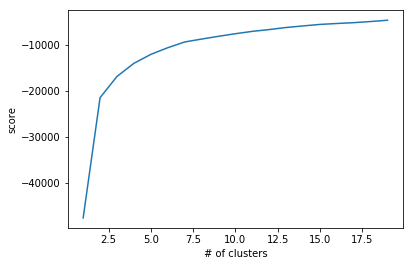

In [4]:
kmeans = [ KMeans(n_clusters=i) for i in range(1,20) ]
score  = [ kmeans[i].fit(data).score(data) for i in range(len(kmeans)) ]

plt.plot( range(1,20), score)
plt.xlabel('# of clusters')
plt.ylabel('score');

Supondo que 3 seja um número razoável: 

In [5]:
km3 = KMeans(n_clusters=3)
km3.fit(data)

d = pos[['id', 'abreviacao']].set_index('id').to_dict()
turn15['cluster'] = km3.predict(data)
turn15.loc[:, 'posicao_nome'] = turn15['posicao_id'].apply( lambda x: d['abreviacao'][x] )

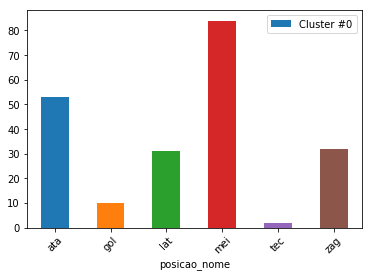

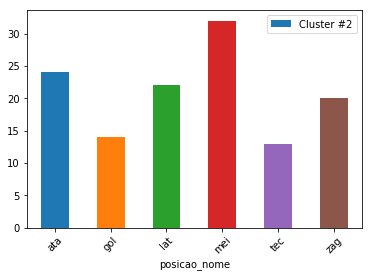

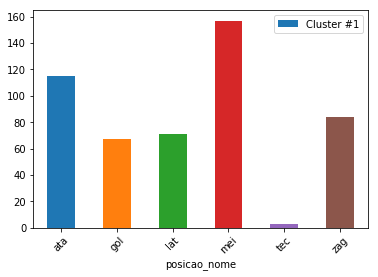

<Figure size 432x288 with 0 Axes>

In [6]:
for c in turn15['cluster'].unique():
    subpop = turn15[turn15['cluster'] == c]
    p = subpop.groupby(['posicao_nome'])['atleta_id'].count()
    p.plot(kind='bar', label = 'Cluster #{}'.format(c), rot=45)
    plt.legend()
    plt.show()
    plt.clf()

Testando com 4 clusters:

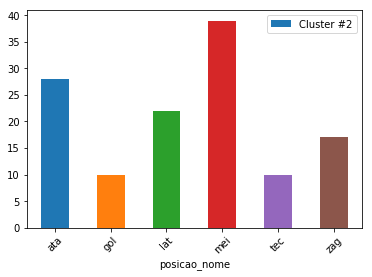

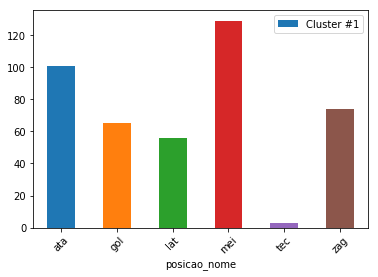

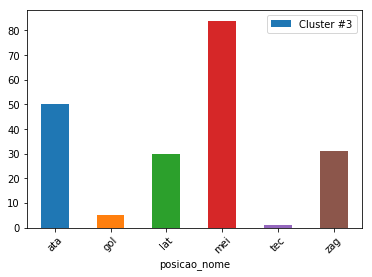

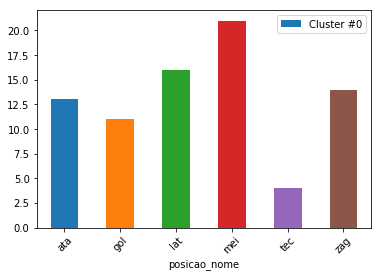

<Figure size 432x288 with 0 Axes>

In [7]:
km3 = KMeans(n_clusters=4)
km3.fit(data)

turn15.loc[:, 'cluster'] = km3.predict(data)

for c in turn15['cluster'].unique():
    subpop = turn15[turn15['cluster'] == c]
    p = subpop.groupby(['posicao_nome'])['atleta_id'].count()
    p.plot(kind='bar', label = 'Cluster #{}'.format(c), rot=45)
    plt.legend()
    plt.show()
    plt.clf()

Testando com a quantidade correta, 5 clusters:

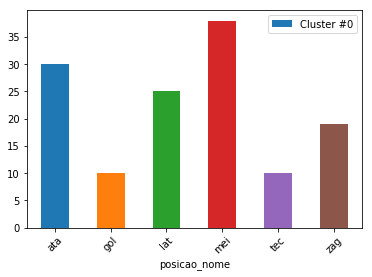

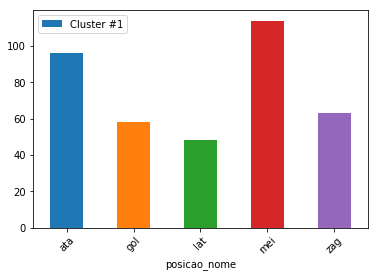

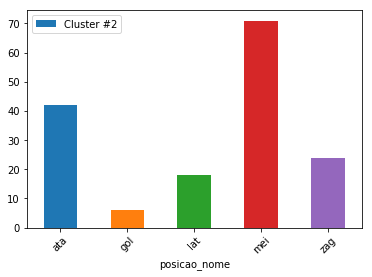

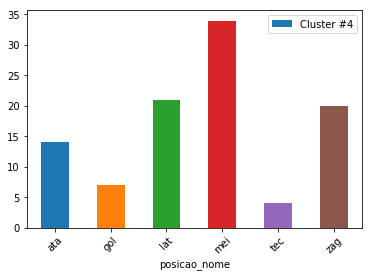

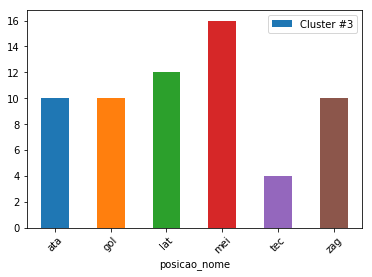

<Figure size 432x288 with 0 Axes>

In [8]:
km3 = KMeans(n_clusters=5)
km3.fit(data)

turn15['cluster'] = km3.predict(data)

for c in turn15['cluster'].unique():
    subpop = turn15[turn15['cluster'] == c]
    p = subpop.groupby(['posicao_nome'])['atleta_id'].count()
    p.plot(kind='bar', label = 'Cluster #{}'.format(c), rot=45)
    plt.legend()
    plt.show()
    plt.clf()

## Tentativa de Predição

In [9]:
pos

,id,nome,abreviacao
0,1,Goleiro,gol
1,2,Lateral,lat
2,3,Zagueiro,zag
3,4,Meia,mei
4,5,Atacante,ata
5,6,Técnico,tec


In [12]:
new = df.sample(1)
display( new )

,atleta_id,rodada_id,clube_id,posicao_id,status_id,pontos_num,preco_num,variacao_num,media_num,jogos_num,...,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS
11333,94978,14,265,5,6,0.0,1.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
display( km3.predict( new[ VARIAVEIS ] ) )

array([1], dtype=int32)

Então um atacante foi classificado como pertecente ao cluster 1.

Como esperado, o modelo não tem o poder preditivo desejado, mas serve como manequim e protótipo para ideias posteriores.

# Testando o `sklearn-porter`

`sklearn-porter` é uma ferramenta que traduz alguns modelos de machine learning em python para outras linguagens, entre elas JavaScript, o que seria desejável para uma aplicação web.

A ideia aqui é testar com uma árvore de decisão **muito** simples, que recebe algumas variáveis e tenta prever se o jogador é atacante sim ou não.

In [14]:
from sklearn_porter import Porter
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

In [15]:
turn15.loc[:, 'striker'] = 0
turn15.loc[turn15['posicao_id']==5, 'striker'] = 1

In [16]:
features =    ['A',
               'CA',
               'CV',
               'DD',
               'DP',
               'FC',
               'FD',
               'FF',
               'FS',
               'FT',
               'G',
               'GC',
               'GS',
               'I',
               'PE',
               'PP',
               'RB',
               'SG',
               #'atleta_id',
               #'clube_id',
               'jogos_num',
               'media_num',
               'pontos_num',
               #'posicao_id',
               'preco_num',
               #'rodada_id',
               #'status_id',
               'variacao_num']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(turn15[features], turn15.striker, 
                                                    test_size=0.3, random_state=13)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(583, 23) (583,)
(251, 23) (251,)


## Modelo

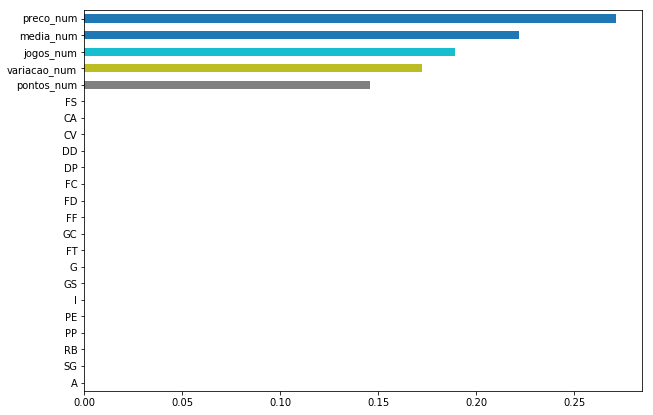

In [18]:
arvore = DecisionTreeClassifier(max_depth=5, random_state=13)
arvore.fit(X_train, y_train)

plt.figure(figsize = (10,7))
pd.Series(arvore.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh');

In [19]:
pred = arvore.predict(X_test)
#pred = arvore.predict_proba(X_test)

In [20]:
lab = list(set(turn15.striker))
conf_matr = confusion_matrix(y_test, pred, labels=lab)
conf_matr

array([[181,   7],
       [ 59,   4]])

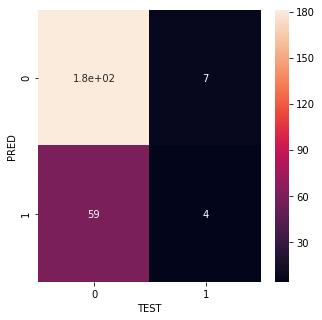

In [21]:
df_conf_matr = pd.DataFrame(conf_matr, 
                            index=[i for i in lab], 
                            columns=[i for i in lab])

plt.figure(figsize = (5,5))
fig = sns.heatmap(df_conf_matr, annot=True)
plt.xlabel('TEST')
plt.ylabel('PRED')
plt.show(fig)

In [22]:
accuracy_score(y_test, pred)

0.7370517928286853

# Testando o port

In [23]:
porter = Porter(arvore, language='js')
output = porter.export(embed_data=True)
print(output)

var DecisionTreeClassifier = function() {

    var findMax = function(nums) {
        var index = 0;
        for (var i = 0; i < nums.length; i++) {
            index = nums[i] > nums[index] ? i : index;
        }
        return index;
    };

    this.predict = function(features) {
        var classes = new Array(2);
            
        if (features[22] <= -2.615000009536743) {
            classes[0] = 0; 
            classes[1] = 3; 
        } else {
            if (features[21] <= 3.834999918937683) {
                if (features[21] <= 3.5549999475479126) {
                    if (features[18] <= 7.5) {
                        if (features[21] <= 2.5749999284744263) {
                            classes[0] = 136; 
                            classes[1] = 51; 
                        } else {
                            classes[0] = 51; 
                            classes[1] = 6; 
                        }
                    } else {
                        if (features[18] <= 8.